In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, precision_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import auc, roc_curve, classification_report

import warnings
warnings.filterwarnings("ignore")

random_state = 42

## Datasets

In [2]:
df = pd.read_csv('../../Data/heart_data_1.csv')
df.head()

,age,gender,height,weight,systolic,diastolic,cholesterol,glucose,smoke,alcohol,active,cardiovascular_disease,BMI
0,50,2,168,62,110,80,1,1,0,0,1,0,21
1,55,1,156,85,140,90,3,1,0,0,1,1,34
2,51,1,165,64,130,70,3,1,0,0,0,1,23
3,48,2,169,82,150,100,1,1,0,0,1,1,28
4,47,1,156,56,100,60,1,1,0,0,0,0,23


In [3]:
df.shape

(70000, 13)

## Train | Validation | Test Split Procedure

In [4]:
# Splitting the datasets and choosing 7 columns that are correlated with the target Column
selector = SelectKBest(k=7, score_func=f_classif)
x = df.drop('cardiovascular_disease', axis=1)
y = df['cardiovascular_disease']
X = selector.fit_transform(x, y)

The `SelectKBest` function is used to select the `k` best features from the dataset, where `k` is specified as `7` in this case. The `f_classif` score function is used to evaluate the significance of each feature based on the correlation between the feature and the target variable.

In the next two lines, the `x` variable is created by dropping the target variable ('cardiovascular_disease') from the dataframe `df`. The `y` variable is set to the target variable.

Finally, the `fit_transform()` method is used to fit the selector to the `x` and `y` data and transform the data to the selected features, which is then stored in the `X` variable.

In [5]:
names = x.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
# Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

    Feat_names     F_Scores
0          age  4202.465728
4  cholesterol  3599.361137
1       weight  2388.711779
6          BMI  1965.669669
5      glucose   562.772977
3    diastolic   303.629011
2     systolic   208.339524


In [6]:
# Split the data into training and testing sets. 80% of data is training data, set aside other 20% for test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

# Remaining 80% is split into valuation and test sets. 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25)

We use the `train_test_split` function to split the data into `training` and `testing` sets. We are using `80%` of the data for training and `20%` for testing. The `training` dataset was further splitted into `train` and `validation` sets with the `validation` set taking `25%`. The `random_state` parameter is set to 42, which ensures that the data is split in the same way every time the code is run.

In [7]:
# Scale the X data
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

The `RobustScaler` is a type of scaling method that is more robust to outliers in the data than other scaling methods, aand since we didn't drop outliers initially this is the best option to use to scale our datasets. It scales the features based on the `median` and `interquartile range (IQR)` of the feature values, which makes it less sensitive to outliers. By scaling the data, the features are transformed to have similar scales, which can improve the performance of some machine learning algorithms that are sensitive to the scale of the data.

In [8]:
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

X_train: (42000, 7)
X_val: (14000, 7)
X_test: (14000, 7)


## Modelling

### Logistic Regression

In [9]:
# Instantiate the models
log_reg = LogisticRegression()
# Fit and evaluate the Logistic Regression model
log_reg.fit(X_train, y_train)
y_val_pred = log_reg.predict(X_val)
y_test_pred = log_reg.predict(X_test)
print("Logistic Regression")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")
print(f"Cross-validation score: {cross_val_score(log_reg, X_train_val, y_train_val, cv=5).mean()}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_test_pred)}")
print(f"Classification report:\n{classification_report(y_test, y_test_pred)}\n")

Logistic Regression
Accuracy on validation set: 0.7143571428571428
Accuracy on test set: 0.7168571428571429
Cross-validation score: 0.7061071428571429
Confusion matrix:
[[5336 1751]
 [2213 4700]]
Classification report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      7087
           1       0.73      0.68      0.70      6913

    accuracy                           0.72     14000
   macro avg       0.72      0.72      0.72     14000
weighted avg       0.72      0.72      0.72     14000




* Accuracy on validation set: 0.7143571428571428 - 
This means that the logistic regression model correctly classified `71.44%` of the instances in the validation set.

* Accuracy on test set: 0.7168571428571429 - 
This means that the logistic regression model correctly classified `71.69%` of the instances in the test set.

* Cross-validation score: 0.7061071428571429- 
This is the average accuracy score of the logistic regression model during cross-validation, which is approximately `70.61%`.

* The classification report provides a summary of the model's performance on each class. The precision, recall, and F1-score metrics are calculated for both classes (0 and 1), as well as the macro and weighted averages across classes. In this case, the logistic regression model achieved a precision of `0.71` and recall of `0.75` for class 0, and a precision of `0.73` and recall of `0.68` for class 1. The overall accuracy on the test set was `0.72`.

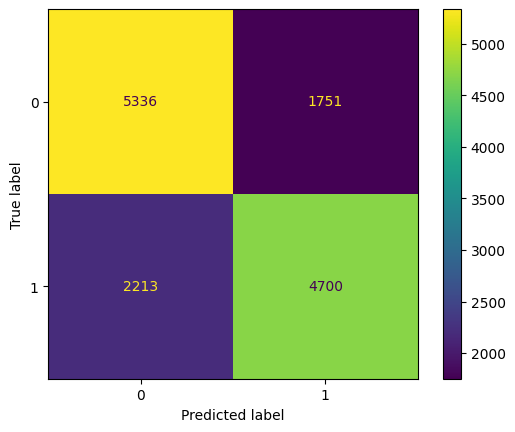

In [10]:
plot_confusion_matrix(log_reg, X_test, y_test);

* Confusion matrix: The confusion matrix shows the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) that the model predicted on the test set. In this case, the model correctly predicted `5336` true negatives and `4700` true positives, but incorrectly predicted `1751` false positives and `2213` false negatives.

### Adaboost Classifier

In [11]:
# Instantiate the models
ada_boost = AdaBoostClassifier()
# Fit and evaluate the Adaboost Classifier model
ada_boost.fit(X_train, y_train)
y_val_pred = ada_boost.predict(X_val)
y_test_pred = ada_boost.predict(X_test)
print("Adaboost Classifier")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")
print(f"Cross-validation score: {cross_val_score(ada_boost, X_train_val, y_train_val, cv=5).mean()}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_test_pred)}")
print(f"Classification report:\n{classification_report(y_test, y_test_pred)}\n")

Adaboost Classifier
Accuracy on validation set: 0.7305714285714285
Accuracy on test set: 0.7282857142857143
Cross-validation score: 0.7306428571428571
Confusion matrix:
[[5609 1478]
 [2326 4587]]
Classification report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      7087
           1       0.76      0.66      0.71      6913

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000




* Accuracy on validation set: 0.7305714285714285 -
This means that the Adaboost Classifier model correctly classified `73.05%` of the instances in the validation set.

* Accuracy on test set: 0.7282857142857143 -
This means that the Adaboost Classifier model correctly classified `72.83%` of the instances in the test set.

* Cross-validation score: 0.7306428571428571 -
This is the average accuracy score of the Adaboost Classifier model during cross-validation, which is approximately `73.06%`.


* The classification report provides a summary of the model's performance on each class. The precision, recall, and F1-score metrics are calculated for both classes (0 and 1), as well as the macro and weighted averages across classes. In this case, the logistic regression model achieved a precision of `0.71` and recall of `0.79` for class 0, and a precision of `0.76` and recall of `0.68` for class 1. The overall accuracy on the test set was `0.73`.

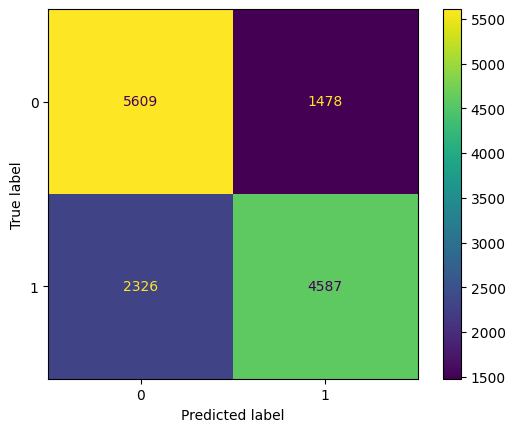

In [12]:
plot_confusion_matrix(ada_boost, X_test, y_test);

* Confusion matrix: The confusion matrix shows the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) that the model predicted on the test set. In this case, the model correctly predicted `5609` true negatives and `4587` true positives, but incorrectly predicted `1478` false positives and `2326` false negatives.

### Gradientboost Classifier

In [13]:
# Instantiate the models
grad_boost = GradientBoostingClassifier()
# Fit and evaluate the Gradientboost Classifier model
grad_boost.fit(X_train, y_train)
y_val_pred = grad_boost.predict(X_val)
y_test_pred = grad_boost.predict(X_test)
print("Gradientboost Classifier")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")
print(f"Cross-validation score: {cross_val_score(grad_boost, X_train_val, y_train_val, cv=5).mean()}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_test_pred)}")
print(f"Classification report:\n{classification_report(y_test, y_test_pred)}\n")

Gradientboost Classifier
Accuracy on validation set: 0.7337857142857143
Accuracy on test set: 0.7322142857142857
Cross-validation score: 0.7357678571428571
Confusion matrix:
[[5410 1677]
 [2072 4841]]
Classification report:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      7087
           1       0.74      0.70      0.72      6913

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000




* Accuracy on validation set: 0.7337857142857143 -
This means that the Gradientboost Classifier model correctly classified `73.38%` of the instances in the validation set.

* Accuracy on test set: 0.7322142857142857 -
This means that the Gradientboost Classifier model correctly classified `73.22%` of the instances in the test set.

* Cross-validation score: 0.7357678571428571 -
This is the average accuracy score of the Gradientboost Classifier model during cross-validation, which is approximately `73.58%`.

* The classification report provides a summary of the model's performance on each class. The precision, recall, and F1-score metrics are calculated for both classes (0 and 1), as well as the macro and weighted averages across classes. In this case, the logistic regression model achieved a precision of `0.72` and recall of `0.76` for class 0, and a precision of `0.74` and recall of `0.70` for class 1. The overall accuracy on the test set was `0.73`.

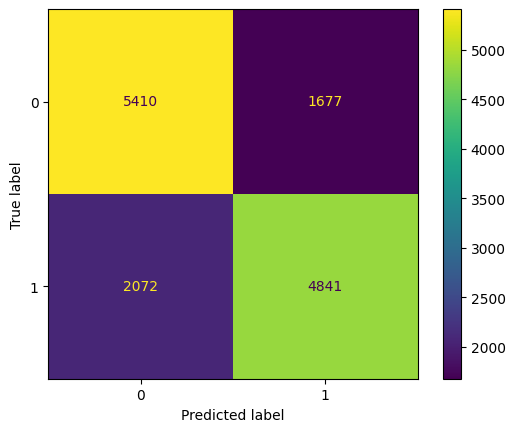

In [14]:
plot_confusion_matrix(grad_boost, X_test, y_test);

* Confusion matrix: The confusion matrix shows the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) that the model predicted on the test set. In this case, the model correctly predicted `5310` true negatives and `4841` true positives, but incorrectly predicted `1677` false positives and `2072` false negatives.

### Random Forest Classifier

In [15]:
# Instantiate the models
rf = RandomForestClassifier()
# Fit and evaluate the Random Forest Classifier model
rf.fit(X_train, y_train)
y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)
print("Random Forest Classifier")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")
print(f"Cross-validation score: {cross_val_score(rf, X_train_val, y_train_val, cv=5).mean()}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_test_pred)}")
print(f"Classification report:\n{classification_report(y_test, y_test_pred)}\n")

Random Forest Classifier
Accuracy on validation set: 0.6923571428571429
Accuracy on test set: 0.6944285714285714
Cross-validation score: 0.6965714285714285
Confusion matrix:
[[4918 2169]
 [2109 4804]]
Classification report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.70      7087
           1       0.69      0.69      0.69      6913

    accuracy                           0.69     14000
   macro avg       0.69      0.69      0.69     14000
weighted avg       0.69      0.69      0.69     14000




* Accuracy on validation set:  0.6923571428571429 -
This means that the Random Forest Classifier model correctly classified `69.23%` of the instances in the validation set.

* Accuracy on test set: 0.6944285714285714 -
This means that the Random Forest Classifier model correctly classified `69.44%` of the instances in the test set.

* Cross-validation score: 0.6965714285714285 -
This is the average accuracy score of the Random Forest Classifier model during cross-validation, which is approximately `69.66%`.

* The classification report provides a summary of the model's performance on each class. The precision, recall, and F1-score metrics are calculated for both classes (0 and 1), as well as the macro and weighted averages across classes. In this case, the logistic regression model achieved a precision of `0.70` and recall of `0.69` for class 0, and a precision of `0.69` and recall of `0.69` for class 1. The overall accuracy on the test set was `0.69`.

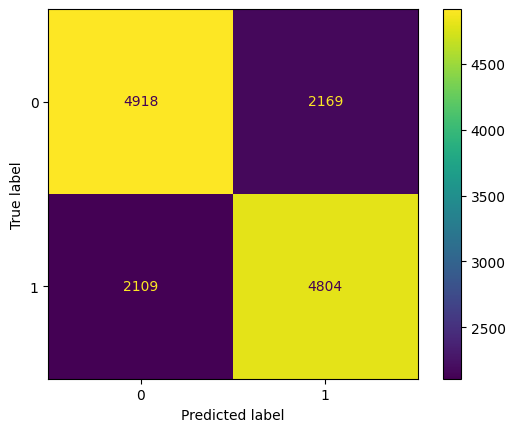

In [16]:
plot_confusion_matrix(rf, X_test, y_test);

* Confusion matrix: The confusion matrix shows the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) that the model predicted on the test set. In this case, the model correctly predicted `4918` true negatives and `4804` true positives, but incorrectly predicted `2109` false positives and `2169` false negatives.

### Hyperparameter Tuning

After checking the performance metrics of each of our model, `Adaboost Classifier` and `Gradientboost Classifier` showed promising results and had higher accuracy, cross-validation scores compared to the other models, therefore we selected them for hyperparameter tuning to further optimize their performance.

#### RandomizedSearchCV

In [17]:
# Define parameter distributions for RandomizedSearchCV
ada_param_dist = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.5),
    'algorithm': ['SAMME', 'SAMME.R']
}

gb_param_dist = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0.1, 0.9),
    'max_depth': randint(3, 10),
    'max_features': ['sqrt', 'log2', None]
}

In [18]:
# Create the Adaboost classifier and perform RandomizedSearchCV
ada = AdaBoostClassifier(random_state=42)
ada_random = RandomizedSearchCV(estimator=ada, param_distributions=ada_param_dist, n_iter=50,
                                cv=5, random_state=42, n_jobs=-1, verbose=2)
ada_random.fit(X_train, y_train)

# Print the best parameters and score for each classifier
print("Best parameters for Adaboost:", ada_random.best_params_)
print("Best score for Adaboost:", ada_random.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END algorithm=SAMME, learning_rate=0.40827149343011643, n_estimators=64; total time=   0.6s
[CV] END algorithm=SAMME, learning_rate=0.40827149343011643, n_estimators=64; total time=   0.6s
[CV] END algorithm=SAMME, learning_rate=0.40827149343011643, n_estimators=64; total time=   0.7s
[CV] END algorithm=SAMME, learning_rate=0.40827149343011643, n_estimators=64; total time=   0.6s
[CV] END algorithm=SAMME, learning_rate=0.40827149343011643, n_estimators=64; total time=   0.6s
[CV] END algorithm=SAMME, learning_rate=0.39984550013638465, n_estimators=70; total time=   0.7s
[CV] END algorithm=SAMME, learning_rate=0.39984550013638465, n_estimators=70; total time=   0.7s
[CV] END algorithm=SAMME, learning_rate=0.39984550013638465, n_estimators=70; total time=   0.6s
[CV] END algorithm=SAMME, learning_rate=0.39984550013638465, n_estimators=70; total time=   0.7s
[CV] END algorithm=SAMME, learning_rate=0.39984550013638465, n_es

In [21]:
# Train Adaboost Classifier with the best hyperparameters
ada_best = AdaBoostClassifier(algorithm='SAMME.R', learning_rate=0.4792763545078751, n_estimators=179, random_state=42)
ada_best.fit(X_train, y_train)

# Evaluate the model on validation set
y_pred = ada_best.predict(X_val)
acc_val = accuracy_score(y_val, y_pred)

# Evaluate the model on test set
y_pred = ada_best.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(ada_best, X_train_val, y_train_val, cv=5)

# ROC_AUC Score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Print the performance metrics
print("AdaBoost Classifier - RandomizedSearchCV")
print("Accuracy on validation set: {:.2f}%".format(acc_val*100))
print("Accuracy on test set: {:.2f}%".format(acc_test*100))
print("Cross-validation score: {:.2f}% (+/- {:.2f}%)".format(cv_scores.mean()*100, cv_scores.std()*2*100))
print("Classification report:\n", classification_report(y_test, y_pred))

AdaBoost Classifier - RandomizedSearchCV
Accuracy on validation set: 73.09%
Accuracy on test set: 72.75%
Cross-validation score: 72.94% (+/- 0.69%)
Classification report:
               precision    recall  f1-score   support

           0       0.70      0.80      0.75      7087
           1       0.76      0.66      0.70      6913

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000



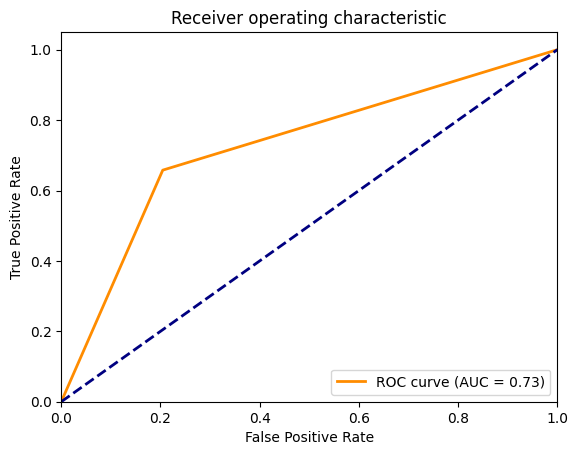

In [22]:
# Plot ROC-AUC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# # save the plot as a JPG image
# plt.savefig('adaboost_randomcv_roc_auc_curve.jpg')
plt.show()

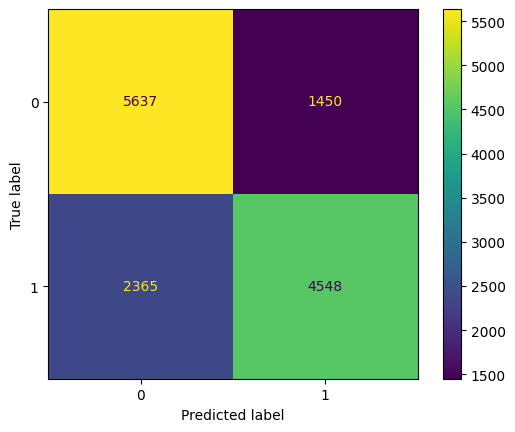

In [23]:
plot_confusion_matrix(ada_best, X_test, y_test);

In [24]:
# Create the Gradientboost classifier and perform RandomizedSearchCV
gb = GradientBoostingClassifier(random_state=42)
gb_random = RandomizedSearchCV(estimator=gb, param_distributions=gb_param_dist, n_iter=50,
                               cv=5, n_jobs=-1, verbose=2)
gb_random.fit(X_train, y_train)
print("Best parameters for GradientBoost:", gb_random.best_params_)
print("Best score for GradientBoost:", gb_random.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.2604826925563352, max_depth=4, max_features=None, n_estimators=289, subsample=0.17549683057613336; total time=   2.9s
[CV] END learning_rate=0.2604826925563352, max_depth=4, max_features=None, n_estimators=289, subsample=0.17549683057613336; total time=   3.0s
[CV] END learning_rate=0.2604826925563352, max_depth=4, max_features=None, n_estimators=289, subsample=0.17549683057613336; total time=   2.8s
[CV] END learning_rate=0.2604826925563352, max_depth=4, max_features=None, n_estimators=289, subsample=0.17549683057613336; total time=   2.9s
[CV] END learning_rate=0.2604826925563352, max_depth=4, max_features=None, n_estimators=289, subsample=0.17549683057613336; total time=   2.9s
[CV] END learning_rate=0.4410733301665911, max_depth=4, max_features=log2, n_estimators=94, subsample=0.21540958019233797; total time=   0.8s
[CV] END learning_rate=0.4410733301665911, max_depth=4, max_features=log2, n_esti

In [28]:
# Train GradientBoosting Classifier with the best hyperparameters
gradboost_best = GradientBoostingClassifier(learning_rate= 0.08422097461921345, max_depth= 3, max_features= None, n_estimators= 138, subsample=  0.36835757927820534, random_state=42)
gradboost_best.fit(X_train, y_train)

# Evaluate the model on validation set
y_pred = gradboost_best.predict(X_val)
acc_val = accuracy_score(y_val, y_pred)

# Evaluate the model on test set
y_pred = gradboost_best.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(gradboost_best, X_train_val, y_train_val, cv=5)

# Print the performance metrics
print("GradientBoost Classifier - RandomizedSearchCV")
print("Accuracy on validation set: {:.2f}%".format(acc_val*100))
print("Accuracy on test set: {:.2f}%".format(acc_test*100))
print("Cross-validation score: {:.2f}% (+/- {:.2f}%)".format(cv_scores.mean()*100, cv_scores.std()*2*100))
print("Classification report:\n", classification_report(y_test, y_pred))

GradientBoost Classifier - RandomizedSearchCV
Accuracy on validation set: 73.61%
Accuracy on test set: 73.23%
Cross-validation score: 73.53% (+/- 0.75%)
Classification report:
               precision    recall  f1-score   support

           0       0.72      0.76      0.74      7087
           1       0.74      0.70      0.72      6913

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000



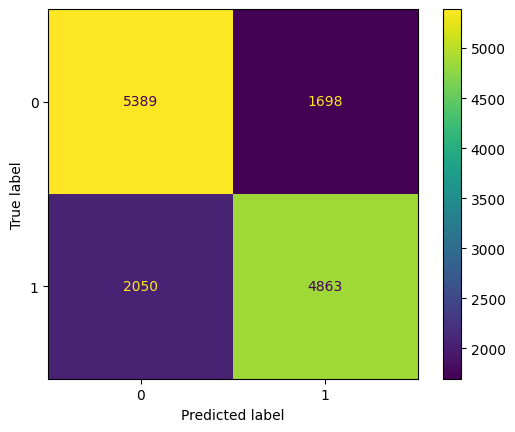

In [29]:
plot_confusion_matrix(gradboost_best, X_test, y_test);

#### GridSearchCV

In [25]:
# Adaboost Classifier
ada_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Gradientboost Classifier
gb_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10]
}

In [26]:
ada_clf = AdaBoostClassifier(random_state=42)

ada_grid = GridSearchCV(ada_clf, param_grid=ada_params, cv=5, n_jobs=-1, scoring='accuracy')
ada_grid.fit(X_train, y_train)

print("Best Adaboost params:", ada_grid.best_params_)
print("Best Adaboost accuracy:", ada_grid.best_score_)

Best Adaboost params: {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 100}
Best Adaboost accuracy: 0.7309523809523808


In [30]:
# Train Adaboost Classifier with the best hyperparameters
ada_grid_best = AdaBoostClassifier(algorithm='SAMME.R', learning_rate=1, n_estimators=100, random_state=42)
ada_grid_best.fit(X_train, y_train)

# Evaluate the model on validation set
y_pred = ada_grid_best.predict(X_val)
acc_val = accuracy_score(y_val, y_pred)

# Evaluate the model on test set
y_pred = ada_grid_best.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(ada_grid_best, X_train_val, y_train_val, cv=5)

# Print the performance metrics
print("AdaBoost Classifier - GridSearchCV")
print("Accuracy on validation set: {:.2f}%".format(acc_val*100))
print("Accuracy on test set: {:.2f}%".format(acc_test*100))
print("Cross-validation score: {:.2f}% (+/- {:.2f}%)".format(cv_scores.mean()*100, cv_scores.std()*2*100))
print("Classification report:\n", classification_report(y_test, y_pred))

AdaBoost Classifier - GridSearchCV
Accuracy on validation set: 73.16%
Accuracy on test set: 72.90%
Cross-validation score: 73.14% (+/- 0.47%)
Classification report:
               precision    recall  f1-score   support

           0       0.71      0.79      0.75      7087
           1       0.75      0.67      0.71      6913

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000



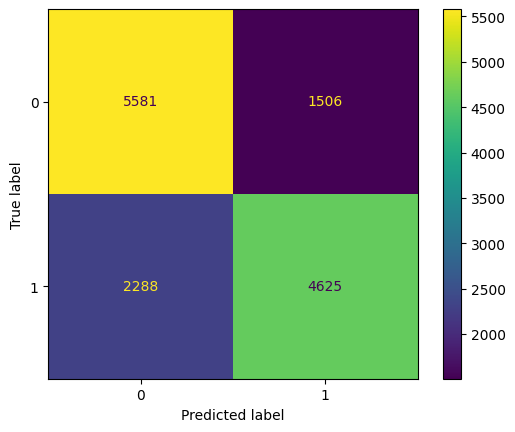

In [31]:
plot_confusion_matrix(ada_grid_best, X_test, y_test);

In [27]:
gb_clf = GradientBoostingClassifier(random_state=42)

gb_grid = GridSearchCV(gb_clf, param_grid=gb_params, cv=5, n_jobs=-1, scoring='accuracy')
gb_grid.fit(X_train, y_train)

print("Best GradientBoosting params:", gb_grid.best_params_)
print("Best GradientBoosting accuracy:", gb_grid.best_score_)

Best GradientBoosting params: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 150}
Best GradientBoosting accuracy: 0.7356904761904761


In [32]:
# Train GradientBoosting Classifier with the best hyperparameters
gradboost_grid_best = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, max_features= 'sqrt', min_samples_split = 5, n_estimators=150, random_state=42)
gradboost_grid_best.fit(X_train, y_train)

# Evaluate the model on validation set
y_pred = gradboost_grid_best.predict(X_val)
acc_val = accuracy_score(y_val, y_pred)

# Evaluate the model on test set
y_pred = gradboost_grid_best.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(gradboost_grid_best, X_train_val, y_train_val, cv=5)

# ROC_AUC Score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Print the performance metrics
print("GradientBoosting - GridSearchCV ")
print("Accuracy on validation set: {:.2f}%".format(acc_val*100))
print("Accuracy on test set: {:.2f}%".format(acc_test*100))
print("Cross-validation score: {:.2f}% (+/- {:.2f}%)".format(cv_scores.mean()*100, cv_scores.std()*2*100))
print("Classification report:\n", classification_report(y_test, y_pred))

GradientBoosting - GridSearchCV 
Accuracy on validation set: 73.37%
Accuracy on test set: 73.28%
Cross-validation score: 73.50% (+/- 0.50%)
Classification report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.74      7087
           1       0.75      0.69      0.72      6913

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000



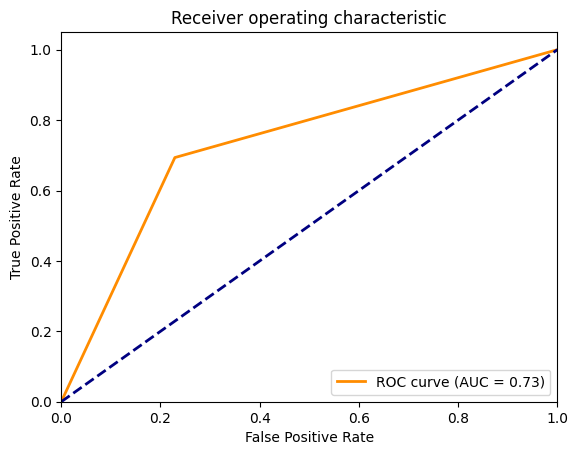

In [33]:
# Plot ROC-AUC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# # save the plot as a JPG image
# plt.savefig('gradboost_gridcv_roc_auc_curve.jpg')
plt.show()

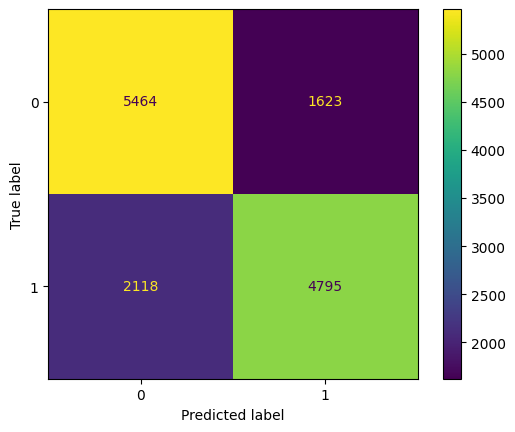

In [34]:
plot_confusion_matrix(gradboost_grid_best, X_test, y_test);

This code defines a range of hyperparameters for both `Adaboost` and `GradientBoosting` classifiers and performs a grid search with cross-validation to find the best set of hyperparameters that maximize accuracy. The `GridSearchCV` object is defined with `cv=5` to use 5-fold cross-validation and `n_jobs=-1` to use all available CPU cores for parallel processing. The scoring parameter is set to `'accuracy'` to optimize for accuracy.

After running the code, the best set of hyperparameters and the corresponding `accuracy` score are printed for each model.

## Implementing Voting-Classifier

This created a DataFrame with columns for the model name, accuracy, precision, recall, and f1-score for both the validation and test sets. With `GradientBoost Classifier GridSearchCV` performing better across all performance metrics.

In [36]:
vc = VotingClassifier(estimators=[
                                ('GradientBoost Classifier GridSearch Best', gradboost_grid_best),
                                ('GradientBoost Classifier Best', gradboost_best)], 
                                voting='hard')
vc.fit(X_train,y_train)

# Evaluate the model on validation set
y_val_pred = vc.predict(X_val)
acc_val = accuracy_score(y_val, y_val_pred)
p_val, r_val, f1_val, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted')

# Evaluate the model on test set
y_test_pred = vc.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
p_test, r_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

# Evaluate the model using cross-validation
cv_scores = cross_val_score(vc, X_train_val, y_train_val, cv=5)

# Print the performance metrics
print("Voting Classifier ")
print("Accuracy on validation set: {:.2f}%".format(acc_val*100))
print("Accuracy on test set: {:.2f}%".format(acc_test*100))
print("Cross-validation score: {:.2f}% (+/- {:.2f}%)".format(cv_scores.mean()*100, cv_scores.std()*2*100))
print("Classification report:\n", classification_report(y_test, y_pred))

Voting Classifier 
Accuracy on validation set: 73.51%
Accuracy on test set: 73.28%
Cross-validation score: 73.54% (+/- 0.57%)
Classification report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.74      7087
           1       0.75      0.69      0.72      6913

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000



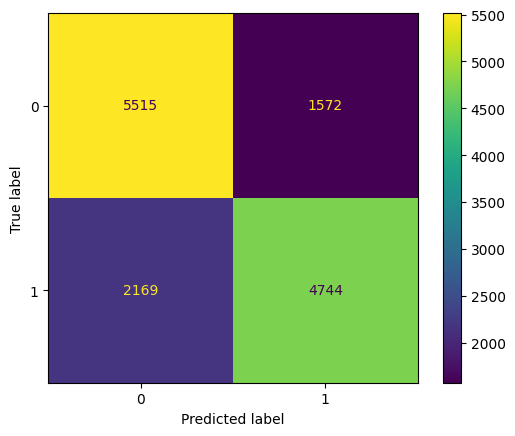

In [37]:
plot_confusion_matrix(vc, X_test, y_test);

## Appending all models

In [38]:
# Define the models
models = [
    ('Logistic Regression', log_reg),
    ('Adaboost Classifier', ada_boost),
    ('Gradientboost Classifier', grad_boost),
    ('Random Forest Classifier', rf),
    ('AdaBoost Classifier Best', ada_best),
    ('GradientBoost Classifier Best', gradboost_best),
    ('AdaBoost Classifier GridSearch Best', ada_grid_best),
    ('GradientBoost Classifier GridSearch Best', gradboost_grid_best),
    ('Voting Classifier', vc)
]

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Evaluate each model and append the results to the DataFrame
for model_name, model in models:
    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_val_pred = model.predict(X_val)
    acc_val = accuracy_score(y_val, y_val_pred)
    p_val, r_val, f1_val, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted')

    # Evaluate the model on the test set
    y_test_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_test_pred)
    p_test, r_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

    # Append the results to the DataFrame
    results_df = results_df.append({
        'Model': model_name,
        'Accuracy': f'Val: {acc_val:.3f}, Test: {acc_test:.3f}',
        'Precision': f'Val: {p_val:.3f}, Test: {p_test:.3f}',
        'Recall': f'Val: {r_val:.3f}, Test: {r_test:.3f}',
        'F1-Score': f'Val: {f1_val:.3f}, Test: {f1_test:.3f}'
    }, ignore_index=True)

# Print the results
results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,"Val: 0.714, Test: 0.717","Val: 0.715, Test: 0.718","Val: 0.714, Test: 0.717","Val: 0.714, Test: 0.716"
1,Adaboost Classifier,"Val: 0.731, Test: 0.728","Val: 0.735, Test: 0.731","Val: 0.731, Test: 0.728","Val: 0.729, Test: 0.727"
2,Gradientboost Classifier,"Val: 0.734, Test: 0.732","Val: 0.735, Test: 0.733","Val: 0.734, Test: 0.732","Val: 0.733, Test: 0.732"
3,Random Forest Classifier,"Val: 0.692, Test: 0.692","Val: 0.692, Test: 0.692","Val: 0.692, Test: 0.692","Val: 0.692, Test: 0.692"
4,AdaBoost Classifier Best,"Val: 0.731, Test: 0.728","Val: 0.736, Test: 0.731","Val: 0.731, Test: 0.728","Val: 0.729, Test: 0.726"
5,GradientBoost Classifier Best,"Val: 0.736, Test: 0.732","Val: 0.737, Test: 0.733","Val: 0.736, Test: 0.732","Val: 0.736, Test: 0.732"
6,AdaBoost Classifier GridSearch Best,"Val: 0.732, Test: 0.729","Val: 0.735, Test: 0.732","Val: 0.732, Test: 0.729","Val: 0.730, Test: 0.728"
7,GradientBoost Classifier GridSearch Best,"Val: 0.734, Test: 0.733","Val: 0.735, Test: 0.734","Val: 0.734, Test: 0.733","Val: 0.733, Test: 0.732"
8,Voting Classifier,"Val: 0.735, Test: 0.733","Val: 0.737, Test: 0.734","Val: 0.735, Test: 0.733","Val: 0.734, Test: 0.732"


In [39]:
sorted_results_df = results_df.sort_values('Precision', ascending=False)
sorted_results_df

,Model,Accuracy,Precision,Recall,F1-Score
8,Voting Classifier,"Val: 0.735, Test: 0.733","Val: 0.737, Test: 0.734","Val: 0.735, Test: 0.733","Val: 0.734, Test: 0.732"
5,GradientBoost Classifier Best,"Val: 0.736, Test: 0.732","Val: 0.737, Test: 0.733","Val: 0.736, Test: 0.732","Val: 0.736, Test: 0.732"
4,AdaBoost Classifier Best,"Val: 0.731, Test: 0.728","Val: 0.736, Test: 0.731","Val: 0.731, Test: 0.728","Val: 0.729, Test: 0.726"
7,GradientBoost Classifier GridSearch Best,"Val: 0.734, Test: 0.733","Val: 0.735, Test: 0.734","Val: 0.734, Test: 0.733","Val: 0.733, Test: 0.732"
2,Gradientboost Classifier,"Val: 0.734, Test: 0.732","Val: 0.735, Test: 0.733","Val: 0.734, Test: 0.732","Val: 0.733, Test: 0.732"
6,AdaBoost Classifier GridSearch Best,"Val: 0.732, Test: 0.729","Val: 0.735, Test: 0.732","Val: 0.732, Test: 0.729","Val: 0.730, Test: 0.728"
1,Adaboost Classifier,"Val: 0.731, Test: 0.728","Val: 0.735, Test: 0.731","Val: 0.731, Test: 0.728","Val: 0.729, Test: 0.727"
0,Logistic Regression,"Val: 0.714, Test: 0.717","Val: 0.715, Test: 0.718","Val: 0.714, Test: 0.717","Val: 0.714, Test: 0.716"
3,Random Forest Classifier,"Val: 0.692, Test: 0.692","Val: 0.692, Test: 0.692","Val: 0.692, Test: 0.692","Val: 0.692, Test: 0.692"


In [47]:
DeepnoteChart(sorted_results_df, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"trail","color":"#f58518","tooltip":true},"encoding":{"x":{"sort":null,"type":"nominal","field":"Model","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"nominal","field":"Precision","scale":{"type":"linear","zero":false}}}},{"mark":{"size":100,"type":"point","opacity":0,"tooltip":true},"encoding":{"x":{"sort":null,"type":"nominal","field":"Model","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"nominal","field":"Precision","scale":{"type":"linear","zero":false}}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

In [48]:
sorted_results_df = results_df.sort_values('Accuracy', ascending=False)
sorted_results_df

,Model,Accuracy,Precision,Recall,F1-Score
5,GradientBoost Classifier Best,"Val: 0.736, Test: 0.732","Val: 0.737, Test: 0.733","Val: 0.736, Test: 0.732","Val: 0.736, Test: 0.732"
8,Voting Classifier,"Val: 0.735, Test: 0.733","Val: 0.737, Test: 0.734","Val: 0.735, Test: 0.733","Val: 0.734, Test: 0.732"
7,GradientBoost Classifier GridSearch Best,"Val: 0.734, Test: 0.733","Val: 0.735, Test: 0.734","Val: 0.734, Test: 0.733","Val: 0.733, Test: 0.732"
2,Gradientboost Classifier,"Val: 0.734, Test: 0.732","Val: 0.735, Test: 0.733","Val: 0.734, Test: 0.732","Val: 0.733, Test: 0.732"
6,AdaBoost Classifier GridSearch Best,"Val: 0.732, Test: 0.729","Val: 0.735, Test: 0.732","Val: 0.732, Test: 0.729","Val: 0.730, Test: 0.728"
1,Adaboost Classifier,"Val: 0.731, Test: 0.728","Val: 0.735, Test: 0.731","Val: 0.731, Test: 0.728","Val: 0.729, Test: 0.727"
4,AdaBoost Classifier Best,"Val: 0.731, Test: 0.728","Val: 0.736, Test: 0.731","Val: 0.731, Test: 0.728","Val: 0.729, Test: 0.726"
0,Logistic Regression,"Val: 0.714, Test: 0.717","Val: 0.715, Test: 0.718","Val: 0.714, Test: 0.717","Val: 0.714, Test: 0.716"
3,Random Forest Classifier,"Val: 0.692, Test: 0.692","Val: 0.692, Test: 0.692","Val: 0.692, Test: 0.692","Val: 0.692, Test: 0.692"


In [53]:
DeepnoteChart(sorted_results_df, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"trail","color":"#439894","tooltip":true},"encoding":{"x":{"sort":null,"type":"nominal","field":"Model","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"nominal","field":"Accuracy","scale":{"type":"linear","zero":false}}}},{"mark":{"size":100,"type":"point","opacity":0,"tooltip":true},"encoding":{"x":{"sort":null,"type":"nominal","field":"Model","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"nominal","field":"Accuracy","scale":{"type":"linear","zero":false}}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7762417b-23bb-4a3d-828e-04b3fea052ca' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>